In [1]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 36.01 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [2]:
!pip3 uninstall keras-nightly
!pip3 uninstall -y tensorflow
!pip3 install keras==2.1.6
!pip3 install tensorflow==1.15.0
!pip3 install h5py==2.10.0
!pip3 install tensorflow-gpu==1.15.0
!pip3 install wget
!pip3 install alphashape

Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 339 kB 5.3 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 25 kB/s 
     |████████████████████████████████| 3.8 MB 47.2 MB/s 
     |████████████████████████████████| 50 kB 1.4 MB/s 
     |████████████████████████████████| 503 kB 634 kB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=9421586b035d006ea994927fbac4ab27209ab7962115655fc22579473434f9d2
  Stored in directory: /root/.cac

In [3]:
import os
import wget
import zipfile
import gdown

def unzip(zip_path, extract_path):
    """extracts the files in a zip file
       in the specified directory
    args:
        zip_path (str): the path to the zip file
        extract_path (str): the path to save the extracted files
    """

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        for file in zip_ref.namelist():
            zip_ref.extract(file, extract_path)

    os.remove(zip_path)
    return

if __name__ == '__main__':
  
  data_path = './'
  print(">> Downloading COCOSearch18 dataset...", end="", flush=True)
  urls = ['http://vision.cs.stonybrook.edu/~cvlab_download/COCOSearch18-images-TP.zip',
          'https://saliency.tuebingen.ai/data/coco_search18_TP.zip']
  for url in urls:
      filename = wget.download(url, data_path)
      unzip(filename, data_path)

  print(">> Downloading Segmentation Annotations...", end="", flush=True)
  url = "https://drive.google.com/uc?export=download&id=1ri6IToZzj9FUcXCK3PHXRhslXhwV4rHV"
  gdown.download(url, os.path.join(data_path, 'annotations.zip'), quiet=False)
  unzip(os.path.join(data_path, 'annotations.zip'), data_path)

  print(">> Downloading target object bounding box annotation...", end="", flush=True)
  url = "https://drive.google.com/uc?id=1OkpX_Md-lFwCo5TB_cq0Qxoe4oEB8eKG"
  output_path = os.path.join(data_path, 'bbox_annos.npy')
  gdown.download(url, output_path, quiet=False)
  print("done!", flush=True)

>> Downloading COCOSearch18 dataset...>> Downloading Segmentation Annotations...

Downloading...
From: https://drive.google.com/uc?export=download&id=1ri6IToZzj9FUcXCK3PHXRhslXhwV4rHV
To: /content/annotations.zip
100%|██████████| 276k/276k [00:00<00:00, 58.6MB/s]

>> Downloading target object bounding box annotation...


Downloading...
From: https://drive.google.com/uc?id=1OkpX_Md-lFwCo5TB_cq0Qxoe4oEB8eKG
To: /content/bbox_annos.npy
100%|██████████| 127k/127k [00:00<00:00, 27.0MB/s]

done!


In [52]:
import numpy as np
import argparse
import alphashape
import os
import json
import random
import cv2
from shapely.geometry import Polygon, Point
import pickle

np.random.seed(42619)

adjusted_width = 512
adjusted_height = 320


def crop_seg(img, pts):
    mask = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    copy_img = img.copy()
    cv2.drawContours(mask, [pts.astype(int)], 0, (255, 255, 255), -1)
    dst = cv2.bitwise_and(copy_img, copy_img, mask=mask)

    return dst


def PolyArea(x, y):
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))


def preprocess(data_dir, category, task_img_pair, human_scanpaths, data_list_ann, phase):
    # We set maximum number of distractors to 20 and compute a distraction score for each distractor
    distraction_scores = np.zeros((len(task_img_pair), 20))

    # Calculate the size and adjusted display size

    show_polys = True
    draw_bbox = False

    fixs = []
    distraction = []
    min_fix_x = 100000
    max_fix_x = -100000
    min_fix_y = 100000
    max_fix_y = -100000

    # dictionary containing the category id of target object category
    cat_id = {'bottle': 1, 'bowl': 4, 'car': 5}
    data = {'images': []}

    rem_list = ['bottle_000000026454.jpg', 'bottle_000000024823.jpg', 'bottle_000000044569.jpg',
                'bottle_000000062348.jpg', 'bottle_000000053491.jpg', 'bottle_000000092288.jpg',
                'bottle_000000134769.jpg', 'bottle_000000204981.jpg', 'bottle_000000283479.jpg',
                'bottle_000000325992.jpg', 'bottle_000000341437.jpg', 'bottle_000000478155.jpg',
                'bottle_000000481185.jpg', 'bottle_000000517068.jpg', 'bottle_000000536127.jpg',
                'bottle_000000541147.jpg', 'bottle_000000553554.jpg', 'bottle_000000580685.jpg',
                'bottle_000000581205.jpg', 'bottle_000000263924.jpg', 'bottle_000000060360.jpg']

    for traj in human_scanpaths:
        for i in range(len(traj['X'])):

            if traj['X'][i] < 0 or traj['Y'][i] < 0 or traj['X'][i] > 1680 or traj['Y'][i] > 1050:
                continue

            if traj['X'][i] < min_fix_x:
                min_fix_x = traj['X'][i]

            if traj['X'][i] > max_fix_x:
                max_fix_x = traj['X'][i]

            if traj['Y'][i] < min_fix_y:
                min_fix_y = traj['Y'][i]

            if traj['Y'][i] > max_fix_y:
                max_fix_y = traj['Y'][i]

    for ind, search_image in enumerate(task_img_pair):

        print('file name:', search_image.split('_')[1])

        if search_image in rem_list:
            continue

        image_path = os.path.join(data_dir, 'images', category, search_image.split('_')[1])

        d = data_list_ann[np.where(data_list_ann[:, 0] == search_image)]
        target = d[np.where(d[:, 4] == cat_id[category])]

        if len(target) == 0:
            print('target is not found!')
            continue

        # remove the target from the list to just include the distractors
        distactors = list(np.delete(d, np.where(d[:, 4] == cat_id[category]), 0))

        print('Number of segmented distractors:', len(distactors))
        img = cv2.resize(cv2.imread(image_path), (adjusted_width, adjusted_height), interpolation=cv2.INTER_AREA)
        # cv2_imshow(img)
        image_width, image_height = int(target[0, 2]), int(target[0, 3])

        poly_t_l = []
        poly_targ = []
        poly_targ_list = []

        # add masked target
        img_new = np.zeros(np.shape(img), dtype="uint8")

        for seg in target[0, 1]:
            poly = np.array(seg).reshape((int(len(seg) / 2), 2))
            img_new = cv2.addWeighted(img_new, 1, crop_seg(img, poly), 1, 1)

            poly_t_l.append([[[poly[i, 0], poly[i, 1]]] for i in range(0, len(poly[:, 0]))])
            poly_targ.append(poly)
            poly_targ_list.append(poly.tolist())

        data['images'].append({
            'file_name': search_image,
            'segmentation': poly_targ_list,
            'label': 11})  # 11 refers to target object

        # cv2_imshow(img_new)

        poly_distractors = []
        count = 0

        for distr in distactors:

            poly_list_dist = []
            distractor_pass = False

            img_f = img_new

            for seg in distr[1]:

                poly = np.array(seg).reshape((int(len(seg) / 2), 2))
                polyg_d = Polygon([(poly[i, 0], poly[i, 1]) for i in range(0, len(poly[:, 0]))])
                alpha_shape = alphashape.alphashape(poly, 0.)

                '''for poly_tar in poly_targ:
    
                  poly_target= Polygon([(poly_tar[i,0], poly_tar[i,1]) for i in range(0, len(poly_tar[:,0]))])
    
                  if poly_target.is_valid:
    
                    intersection = alpha_shape.intersection(poly_target)
                    percent_area = intersection.area / alpha_shape.area * 100
                    #print(percent_area)
                    if (poly_target.contains(polyg_d) or percent_area > 75.0):            
                      distractor_pass=True
    
                    if len(poly_distractors)!=0:
                      for l in poly_distractors:
                        for p in l:
                          p_d= Polygon([(p[i,0], p[i,1]) for i in range(0, len(p[:,0]))])
                          if p_d.is_valid:
                            intersection = alpha_shape.intersection(p_d)
                            percent_area = intersection.area / alpha_shape.area * 100
    
                            if (p_d.contains(polyg_d) or percent_area > 75.0): 
                              distractor_pass=True
    
                print('\n')
    
                if (PolyArea(poly[:,0],poly[:,1])> 100000):
                  distractor_pass=True'''

                if not (distractor_pass):
                    img_f = cv2.addWeighted(img_f, 1, crop_seg(img, poly), 1, 1)
                    poly_list_dist.append(poly.tolist())

            if not distractor_pass:

                count += 1
                if count > 20:
                    continue

                cv2.imwrite(os.path.join(data_dir, 'distractor_target_pair', str(phase),
                                         search_image.split('.')[0] + '_' + str(count) + '.jpg'), img_f)
                # cv2_imshow(img_f)
                poly_distractors.append(poly_list_dist)

        observer = np.zeros((len(poly_distractors)))
        observer_new = np.zeros((len(poly_distractors)))

        for traj in human_scanpaths:

            if (traj['name'] == search_image.split('_')[1]) and (traj['task'] == category):

                observer[:] += 1
                # first fixations are fixed at the screen center
                traj['X'][0], traj['Y'][0] = adjusted_width / 2, adjusted_height / 2
                fixs = [(traj['X'][0], traj['Y'][0])]

                traj_len = len(traj['X'])

                for i in range(1, traj_len):

                    fix = (
                        ((traj['X'][i] - min_fix_x) / max_fix_x) * (512),
                        ((traj['Y'][i] - min_fix_y) / max_fix_y) * (320))

                    # remove returning fixations (enforce inhibition of return)
                    if fix in fixs:
                        continue
                    else:
                        fixs.append(fix)

                    target_fixation = False
                    # print(fix)
                    for poly_t in poly_t_l:

                        # check whether the fixation lies on the polygon
                        c = cv2.pointPolygonTest(np.asarray(poly_t).astype(int), (fix[0], fix[1]), measureDist=False)

                        if c >= 0:
                            target_fixation = True

                    if target_fixation:
                        continue

                    for index, poly_g_l in enumerate(poly_distractors):
                        for polyg in np.asarray(poly_g_l):
                            # for polyg in item:
                            # polyg_dist = Polygon([(polyg[i,0], polyg[i,1]) for i in range(0, len(polyg[:,0]))])
                            c = cv2.pointPolygonTest(np.asarray(polyg).astype(int), (fix[0], fix[1]), measureDist=False)
                            # point = Point(fix[0],fix[1])

                            if c >= 0 and observer[index] != observer_new[index]:
                                # print('fixation on distractor')
                                # print('index of fixated distractor object:', index)
                                distraction_scores[ind, index] += 1
                                observer_new[index] = observer[index]

                                # print(observer)
        # np.sum(distraction_scores[ind, :])
        for j, s in enumerate(distraction_scores[ind, :]):

            if os.path.exists(os.path.join(data_dir, 'distractor_target_pair', str(phase),
                                           search_image.split('.')[0] + '_' + str(j + 1) + '.jpg')):
                print('distractor index: ', j)
                print('len(poly_distractors): ', len(poly_distractors))
                distraction.append(int(s))
                data['images'].append({
                    'file_name': search_image,
                    'segmentation': poly_distractors[j],
                    'label': int(s)})

        # print('distractor score for distractors:', distraction_scores[ind, :])

    return data


def mask_seg(mask, pts, label, color):
    new_mask = cv2.fillPoly(mask, [pts.astype(int)], label)  # color[label])

    return new_mask


def process_mask(data_dir, category, data, phase, classification):
    # dictionary for assigning a different color for each distraction mask
    color = {0: (0, 0, 20), 1: (0, 0, 40), 2: (0, 0, 80),
             3: (0, 0, 100), 4: (0, 0, 120), 5: (0, 0, 140),
             6: (0, 0, 160), 7: (0, 0, 180), 8: (0, 0, 200),
             9: (0, 0, 220), 10: (0, 0, 255), 11: (0, 255, 0)}

    task_img_pair = []

    for traj in data['images']:
        task_img_pair.append(traj['file_name'])

    task_img_pair = np.unique(np.asarray(task_img_pair))

    for im in task_img_pair:
        image_path = os.path.join(data_dir, 'images', category, im.split('_')[1])
        img = cv2.resize(cv2.imread(image_path), (adjusted_width, adjusted_height), interpolation=cv2.INTER_AREA)
        cv2.imwrite(os.path.join(data_dir, 'distraction', phase, im.split('.')[0] + '.png'), img)

        instances = 0

        for traj in data['images']:
            if traj['file_name'] == im and traj['label'] > 0:
                # print(traj['label'])
                instances += 1
        # print(instances)

        mask = np.zeros((img.shape[0], img.shape[1], instances), dtype="uint8")

        channel = 0

        for traj in data['images']:
            if traj['file_name'] == im:

                label = traj['label']

                if int(classification)==2: ##2 classes
                  if label == 11:  # write target masks on the first channel
                      for seg in traj['segmentation']:
                          poly = np.array(seg)
                          mask[:, :, channel] = mask_seg(mask[:, :, channel].astype("uint8"), poly, 1, color)

                      channel += 1

                  if label > 0 and label < 11:

                      for seg in traj['segmentation']:
                          poly = np.array(seg)
                          mask[:, :, channel] = mask_seg(mask[:, :, channel].astype("uint8"), poly, 2, color)
                      channel += 1

                elif int(classification)==3:  ##3 classes
                  if label==11: #write target masks on the first channel
                    for seg in traj['segmentation']:
                        poly = np.array(seg)                   
                        mask[:,:,channel]  = mask_seg(mask[:,:,channel].astype("uint8") , poly , 1 , color)
                    channel +=1

                  if label>0 and label<3:#write lowly distractors          
                    for seg in traj['segmentation']:
                        poly = np.array(seg)                   
                        mask[:,:,channel]  = mask_seg(mask[:,:,channel].astype("uint8") , poly , 2 , color)
                    channel +=1

                  
                  elif label>=3 and label<11: #write highly distractors
                    for seg in traj['segmentation']:
                        poly = np.array(seg)                   
                        mask[:,:,channel]  = mask_seg(mask[:,:,channel].astype("uint8") , poly , 3 , color)
                    channel +=1    

        # print(np.unique(mask))
        print([np.max(mask[:,:,i]) for i in range(mask.shape[-1])])

        with open(os.path.join(data_dir, 'distraction', 'mask', im.split('.')[0] + '.pickle'), "wb") as f_out:
            pickle.dump(mask, f_out)


if __name__ == '__main__':

    dldir = './'
    print('Enter the target category (bottle, car, bowl)')
    category = str(input())

    print('type 2 if you only want a binary classification (target-distractor) \n type 3 if you want to detect low distractors, high distractors and targets')
    classification = input()

    if not os.path.exists(os.path.join(dldir, 'distractor_target_pair')):
        os.mkdir(os.path.join(dldir, 'distractor_target_pair'))
    if not os.path.exists(os.path.join(dldir, 'distractor_target_pair', 'train')):
        os.mkdir(os.path.join(dldir, 'distractor_target_pair', 'train'))
    if not os.path.exists(os.path.join(dldir, 'distractor_target_pair', 'valid')):
        os.mkdir(os.path.join(dldir, 'distractor_target_pair', 'valid'))
    if not os.path.exists(os.path.join(dldir, 'distractor_target_pair', 'test')):
        os.mkdir(os.path.join(dldir, 'distractor_target_pair', 'test'))
    if not os.path.exists(os.path.join(dldir, 'distraction')):
        os.mkdir(os.path.join(dldir, 'distraction'))
    if not os.path.exists(os.path.join(dldir, 'distraction', 'train')):
        os.mkdir(os.path.join(dldir, 'distraction', 'train'))
    if not os.path.exists(os.path.join(dldir, 'distraction', 'valid')):
        os.mkdir(os.path.join(dldir, 'distraction', 'valid'))
    if not os.path.exists(os.path.join(dldir, 'distraction', 'test')):
        os.mkdir(os.path.join(dldir, 'distraction', 'test'))
    if not os.path.exists(os.path.join(dldir, 'distraction', 'mask')):
        os.mkdir(os.path.join(dldir, 'distraction', 'mask'))

    with open(os.path.join(dldir,
                           'coco_search18_fixations_TP_train_split1.json')) as json_file:
        human_scanpaths_train = json.load(json_file)

    with open(os.path.join(dldir,
                           'coco_search18_fixations_TP_validation_split1.json')) as json_file:
        human_scanpaths_valid = json.load(json_file)

    train_task_img_pair = []

    for search_image in human_scanpaths_train:
        if search_image['task'] == category:
            train_task_img_pair.append(category + '_' + search_image['name'])
    train_task_img_pair = np.unique(np.asarray(train_task_img_pair))

    # separate test set from the training set.
    test_task_img_pair = random.sample(list(train_task_img_pair), 17)

    # remove test set from the training set
    train_task_img_pair = [x for x in train_task_img_pair if x not in test_task_img_pair]
    train_task_img_pair = np.unique(np.asarray(train_task_img_pair))

    valid_task_img_pair = []

    for search_image in human_scanpaths_valid:
        if search_image['task'] == category:
            valid_task_img_pair.append(category + '_' + search_image['name'])
    valid_task_img_pair = np.unique(np.asarray(valid_task_img_pair))

    with open(os.path.join(dldir, category + '_segmentation.json')) as json_file:
        annotations = json.load(json_file)

    data_list = []
    for traj in annotations['images']:
        if traj["file_name"] in train_task_img_pair:
            data_list.append((traj["file_name"], traj["id"], traj['width'], traj['height']))

    data_list = np.asarray(data_list)
    data_list_ann = []

    test_list = []
    for traj in annotations['images']:
        if traj["file_name"] in test_task_img_pair:
            test_list.append((traj["file_name"], traj["id"], traj['width'], traj['height']))

    test_list = np.asarray(test_list)
    test_list_ann = []

    for traj in annotations['annotations']:
        if str(traj["image_id"]) in data_list[:, 1]:
            d = data_list[np.where(data_list[:, 1] == str(traj["image_id"]))][0]
            data_list_ann.append([d[0], traj['segmentation'], d[2], d[3],
                                  traj['category_id']])  # [filename, segmentation, width, height, category]
    data_list_ann = np.asarray(data_list_ann)

    for traj in annotations['annotations']:
        if str(traj["image_id"]) in test_list[:, 1]:
            d = test_list[np.where(test_list[:, 1] == str(traj["image_id"]))][0]
            test_list_ann.append([d[0], traj['segmentation'], d[2], d[3],
                                  traj['category_id']])  # [filename, segmentation, width, height, category]
    test_list_ann = np.asarray(test_list_ann)

    valid_list = []
    for traj in annotations['images']:
        if traj["file_name"] in valid_task_img_pair:
            valid_list.append((traj["file_name"], traj["id"], traj['width'], traj['height']))

    valid_list = np.asarray(valid_list)
    valid_list_ann = []

    for traj in annotations['annotations']:
        if str(traj["image_id"]) in valid_list[:, 1]:
            d = valid_list[np.where(valid_list[:, 1] == str(traj["image_id"]))][0]
            valid_list_ann.append([d[0], traj['segmentation'], d[2], d[3],
                                   traj['category_id']])  # [filename, segmentation, width, height, category]
    valid_list_ann = np.asarray(valid_list_ann)

    data_train = preprocess(dldir, category, train_task_img_pair, human_scanpaths_train, data_list_ann,
                            'train')
    # with open(os.path.join(dldir, 'training.txt'), 'w') as outfile:
    #     json.dump(data_train, outfile)

    data_valid = preprocess(dldir, category, valid_task_img_pair, human_scanpaths_valid, valid_list_ann,
                            'valid')
    # with open(os.path.join(dldir, 'validating.txt'), 'w') as outfile:
    #     json.dump(data_valid, outfile)

    data_test = preprocess(dldir, category, test_task_img_pair, human_scanpaths_train, test_list_ann,
                           'test')
    # with open(os.path.join(dldir, 'testing.txt'), 'w') as outfile:
    #     json.dump(data_test, outfile)
    process_mask(dldir, category, data_train, 'train', classification)
    process_mask(dldir, category, data_valid, 'valid', classification)
    process_mask(dldir, category, data_test, 'test', classification)

Enter the target category (bottle, car, bowl)
bottle
type 2 if you only want a binary classification (target-distractor) 
 type 3 if you want to detect low distractors, high distractors and targets
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:417: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:424: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:439: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


file name: 000000018658.jpg
Number of segmented distractors: 13
distractor index:  0
len(poly_distractors):  13
distractor index:  1
len(poly_distractors):  13
distractor index:  2
len(poly_distractors):  13
distractor index:  3
len(poly_distractors):  13
distractor index:  4
len(poly_distractors):  13
distractor index:  5
len(poly_distractors):  13
distractor index:  6
len(poly_distractors):  13
distractor index:  7
len(poly_distractors):  13
distractor index:  8
len(poly_distractors):  13
distractor index:  9
len(poly_distractors):  13
distractor index:  10
len(poly_distractors):  13
distractor index:  11
len(poly_distractors):  13
distractor index:  12
len(poly_distractors):  13
file name: 000000021190.jpg
Number of segmented distractors: 3
distractor index:  0
len(poly_distractors):  3
distractor index:  1
len(poly_distractors):  3
distractor index:  2
len(poly_distractors):  3
file name: 000000023906.jpg
Number of segmented distractors: 7
distractor index:  0
len(poly_distractors)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:221: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


distractor index:  0
len(poly_distractors):  3
distractor index:  1
len(poly_distractors):  3
distractor index:  2
len(poly_distractors):  3
file name: 000000047949.jpg
Number of segmented distractors: 3
distractor index:  0
len(poly_distractors):  3
distractor index:  1
len(poly_distractors):  3
distractor index:  2
len(poly_distractors):  3
file name: 000000051047.jpg
Number of segmented distractors: 9
distractor index:  0
len(poly_distractors):  9
distractor index:  1
len(poly_distractors):  9
distractor index:  2
len(poly_distractors):  9
distractor index:  3
len(poly_distractors):  9
distractor index:  4
len(poly_distractors):  9
distractor index:  5
len(poly_distractors):  9
distractor index:  6
len(poly_distractors):  9
distractor index:  7
len(poly_distractors):  9
distractor index:  8
len(poly_distractors):  9
file name: 000000053047.jpg
Number of segmented distractors: 3
distractor index:  0
len(poly_distractors):  3
distractor index:  1
len(poly_distractors):  3
distractor i

In [53]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd
import cv2
import pickle
import tensorflow as tf
import keras
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import visualize
from mrcnn.visualize import display_images
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join('./', "distraction/")

TRAIN_PATH = './distraction/train/'
VALID_PATH = './distraction/valid/'
TEST_PATH = './distraction/test/'
MASK_DIR = os.path.join(IMAGE_DIR, "mask")
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[2]
valid_ids = next(os.walk(VALID_PATH))[2]
test_ids = next(os.walk(TEST_PATH))[2]

In [54]:
class ShapesConfig(coco.CocoConfig):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + int(classification)  # background + low distractor, high distractor, target

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_SHAPE = (320 , 512 ,3)
    #IMAGE_RESIZE_MODE = ""
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = ( 8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 800

    # set number of epoch
    STEPS_PER_EPOCH = 83

    # set validation steps 
    VALIDATION_STEPS = 16
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [55]:
class ShapesDataset(utils.Dataset):
    
    def load_shapes(self, mode):
        
        # Add classes
        if int(classification)==2:
            self.add_class("shapes", 1, "target")
            self.add_class("shapes", 2, "distractor")

        elif int(classification)==3:
            self.add_class("shapes", 1, "target")
            self.add_class("shapes", 2, "low-distractor")
            self.add_class("shapes", 3, "high distractor")
        # Get train and test IDs
        self.train_ids = next(os.walk(TRAIN_PATH))[2]
        self.valid_ids = next(os.walk(VALID_PATH))[2]
        self.test_ids = next(os.walk(TEST_PATH))[2]

        if mode == "train":  
            for n, id_ in enumerate(self.train_ids):
                #path = TRAIN_PATH + id_
                self.add_image("shapes", image_id=id_, path=TRAIN_PATH)
              
        if mode == "val":   
            for n, id_ in enumerate(self.valid_ids):
                  #path = VALID_PATH + id_ 
                  self.add_image("shapes", image_id=id_, path=VALID_PATH)   
        
        if mode == "test":   
            for n, id_ in enumerate(self.test_ids):
                  #path = TEST_PATH + id_
                  self.add_image("shapes", image_id=id_, path=TEST_PATH)    


    def load_image(self, image_id):
        
        info = self.image_info[image_id]
        info = info.get("id")
       
        path = TRAIN_PATH + info
        
        if info in self.train_ids:
           path = TRAIN_PATH + info
        elif info in self.valid_ids:
           path = VALID_PATH + info
        else:
           path = TEST_PATH + info

        img = imread(path)[:,:,:3]
        img = resize(img, (320, 512), mode='constant', preserve_range=True)
       
        return img

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        
        info = self.image_info[image_id]
        info = info.get("id")

        path = os.path.join(MASK_DIR , info.split('.')[0]+ '.pickle')
        with open(path, "rb") as f_in:
          mask = pickle.load(f_in)
          #print(np.unique(mask))
          number_of_masks = mask.shape[-1]
          #print(number_of_masks)

        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(number_of_masks-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
            
        # Map class names to class IDs.
        class_ids = np.asarray([np.max(mask[:,:,i]) for i in range(number_of_masks)])
        mask[mask > 1] = 1
        #print(class_ids )

        return mask, class_ids.astype(np.int32)

In [56]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes("train")
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes("val")
dataset_val.prepare()

dataset_test = ShapesDataset()
dataset_test.load_shapes("test")
dataset_test.prepare()


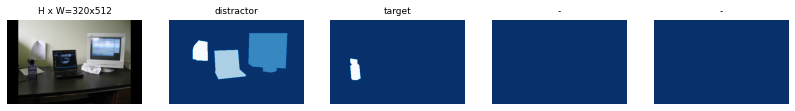

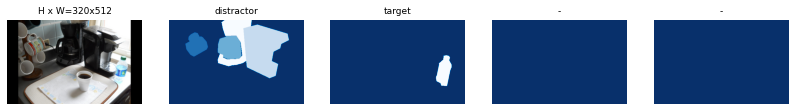

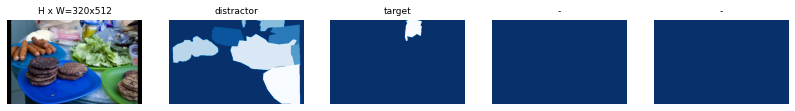

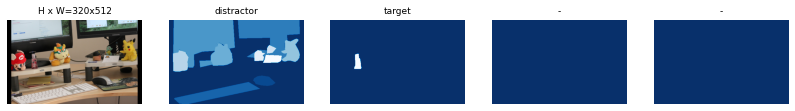

In [57]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id )
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [58]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [59]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
filepath = './' + "unet_best_weight.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [ checkpoint]
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads',
            custom_callbacks=callbacks_list)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/shapes20220626T0017/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessi

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 2/83 [..............................] - ETA: 12:53 - loss: 7.1846 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 0.8682 - mrcnn_class_loss: 3.8244 - mrcnn_bbox_loss: 0.9812 - mrcnn_mask_loss: 1.4367

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/83 [>.............................] - ETA: 6:46 - loss: 6.4360 - rpn_class_loss: 0.1002 - rpn_bbox_loss: 1.0267 - mrcnn_class_loss: 2.3454 - mrcnn_bbox_loss: 1.3703 - mrcnn_mask_loss: 1.5935

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/83 [=>............................] - ETA: 4:43 - loss: 5.4788 - rpn_class_loss: 0.1125 - rpn_bbox_loss: 1.0244 - mrcnn_class_loss: 1.5680 - mrcnn_bbox_loss: 1.4392 - mrcnn_mask_loss: 1.3346

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/83 [=>............................] - ETA: 3:40 - loss: 5.0385 - rpn_class_loss: 0.1075 - rpn_bbox_loss: 0.9606 - mrcnn_class_loss: 1.1902 - mrcnn_bbox_loss: 1.5054 - mrcnn_mask_loss: 1.2748

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/83 [==>...........................] - ETA: 3:02 - loss: 4.6804 - rpn_class_loss: 0.0986 - rpn_bbox_loss: 0.9304 - mrcnn_class_loss: 0.9666 - mrcnn_bbox_loss: 1.4722 - mrcnn_mask_loss: 1.2126

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/83 [===>..........................] - ETA: 2:36 - loss: 4.4379 - rpn_class_loss: 0.1112 - rpn_bbox_loss: 0.9598 - mrcnn_class_loss: 0.8101 - mrcnn_bbox_loss: 1.4131 - mrcnn_mask_loss: 1.1438

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/83 [===>..........................] - ETA: 2:26 - loss: 4.3033 - rpn_class_loss: 0.1054 - rpn_bbox_loss: 0.9774 - mrcnn_class_loss: 0.7510 - mrcnn_bbox_loss: 1.3807 - mrcnn_mask_loss: 1.0887

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/83 [====>.........................] - ETA: 2:18 - loss: 4.2258 - rpn_class_loss: 0.1076 - rpn_bbox_loss: 0.9958 - mrcnn_class_loss: 0.6991 - mrcnn_bbox_loss: 1.3450 - mrcnn_mask_loss: 1.0783

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/83 [====>.........................] - ETA: 2:03 - loss: 4.0255 - rpn_class_loss: 0.0965 - rpn_bbox_loss: 0.9914 - mrcnn_class_loss: 0.6200 - mrcnn_bbox_loss: 1.3210 - mrcnn_mask_loss: 0.9966

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/83 [=====>........................] - ETA: 1:52 - loss: 3.8188 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 0.9633 - mrcnn_class_loss: 0.5641 - mrcnn_bbox_loss: 1.2790 - mrcnn_mask_loss: 0.9211

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/83 [======>.......................] - ETA: 1:42 - loss: 3.6602 - rpn_class_loss: 0.0915 - rpn_bbox_loss: 0.9359 - mrcnn_class_loss: 0.5131 - mrcnn_bbox_loss: 1.2356 - mrcnn_mask_loss: 0.8842

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/83 [======>.......................] - ETA: 1:34 - loss: 3.5238 - rpn_class_loss: 0.0848 - rpn_bbox_loss: 0.9100 - mrcnn_class_loss: 0.4689 - mrcnn_bbox_loss: 1.2209 - mrcnn_mask_loss: 0.8392

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/83 [=======>......................] - ETA: 1:31 - loss: 3.4505 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 0.8949 - mrcnn_class_loss: 0.4517 - mrcnn_bbox_loss: 1.2025 - mrcnn_mask_loss: 0.8180

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/83 [========>.....................] - ETA: 1:24 - loss: 3.3693 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 0.8706 - mrcnn_class_loss: 0.4194 - mrcnn_bbox_loss: 1.2086 - mrcnn_mask_loss: 0.7911

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/83 [========>.....................] - ETA: 1:21 - loss: 3.3237 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 0.8790 - mrcnn_class_loss: 0.4076 - mrcnn_bbox_loss: 1.1823 - mrcnn_mask_loss: 0.7716

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/83 [=========>....................] - ETA: 1:15 - loss: 3.2067 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 0.8502 - mrcnn_class_loss: 0.3820 - mrcnn_bbox_loss: 1.1542 - mrcnn_mask_loss: 0.7402

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/83 [=========>....................] - ETA: 1:10 - loss: 3.1337 - rpn_class_loss: 0.0818 - rpn_bbox_loss: 0.8411 - mrcnn_class_loss: 0.3620 - mrcnn_bbox_loss: 1.1344 - mrcnn_mask_loss: 0.7145

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/83 [==========>...................] - ETA: 1:06 - loss: 3.0672 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 0.8314 - mrcnn_class_loss: 0.3445 - mrcnn_bbox_loss: 1.1168 - mrcnn_mask_loss: 0.6919

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/83 [===========>..................] - ETA: 1:02 - loss: 2.9764 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 0.8177 - mrcnn_class_loss: 0.3284 - mrcnn_bbox_loss: 1.0796 - mrcnn_mask_loss: 0.6691

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/83 [============>.................] - ETA: 58s - loss: 2.8856 - rpn_class_loss: 0.0809 - rpn_bbox_loss: 0.7942 - mrcnn_class_loss: 0.3127 - mrcnn_bbox_loss: 1.0556 - mrcnn_mask_loss: 0.6422 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/83 [============>.................] - ETA: 54s - loss: 2.8270 - rpn_class_loss: 0.0798 - rpn_bbox_loss: 0.7837 - mrcnn_class_loss: 0.3005 - mrcnn_bbox_loss: 1.0366 - mrcnn_mask_loss: 0.6263

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/83 [=============>................] - ETA: 51s - loss: 2.7740 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 0.7789 - mrcnn_class_loss: 0.2904 - mrcnn_bbox_loss: 1.0203 - mrcnn_mask_loss: 0.6051

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/83 [=============>................] - ETA: 49s - loss: 2.7506 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 0.7753 - mrcnn_class_loss: 0.2842 - mrcnn_bbox_loss: 1.0135 - mrcnn_mask_loss: 0.5971

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/83 [==============>...............] - ETA: 46s - loss: 2.7154 - rpn_class_loss: 0.0816 - rpn_bbox_loss: 0.7679 - mrcnn_class_loss: 0.2731 - mrcnn_bbox_loss: 1.0090 - mrcnn_mask_loss: 0.5838

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/83 [===============>..............] - ETA: 43s - loss: 2.6751 - rpn_class_loss: 0.0814 - rpn_bbox_loss: 0.7641 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.9884 - mrcnn_mask_loss: 0.5775

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/83 [===============>..............] - ETA: 40s - loss: 2.6406 - rpn_class_loss: 0.0812 - rpn_bbox_loss: 0.7582 - mrcnn_class_loss: 0.2565 - mrcnn_bbox_loss: 0.9687 - mrcnn_mask_loss: 0.5761

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/83 [================>.............] - ETA: 38s - loss: 2.6081 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 0.7478 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.9592 - mrcnn_mask_loss: 0.5694

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/83 [=================>............] - ETA: 36s - loss: 2.5682 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 0.7420 - mrcnn_class_loss: 0.2443 - mrcnn_bbox_loss: 0.9464 - mrcnn_mask_loss: 0.5570

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


52/83 [=================>............] - ETA: 33s - loss: 2.5233 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 0.7288 - mrcnn_class_loss: 0.2370 - mrcnn_bbox_loss: 0.9343 - mrcnn_mask_loss: 0.5466

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


54/83 [==================>...........] - ETA: 31s - loss: 2.4847 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.7234 - mrcnn_class_loss: 0.2303 - mrcnn_bbox_loss: 0.9174 - mrcnn_mask_loss: 0.5368

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


55/83 [==================>...........] - ETA: 29s - loss: 2.4587 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.7146 - mrcnn_class_loss: 0.2269 - mrcnn_bbox_loss: 0.9101 - mrcnn_mask_loss: 0.5316

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


57/83 [===================>..........] - ETA: 27s - loss: 2.4138 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 0.6993 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.8904 - mrcnn_mask_loss: 0.5296

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


59/83 [====================>.........] - ETA: 24s - loss: 2.3747 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 0.6891 - mrcnn_class_loss: 0.2151 - mrcnn_bbox_loss: 0.8760 - mrcnn_mask_loss: 0.5217

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


61/83 [=====================>........] - ETA: 22s - loss: 2.3454 - rpn_class_loss: 0.0722 - rpn_bbox_loss: 0.6837 - mrcnn_class_loss: 0.2089 - mrcnn_bbox_loss: 0.8640 - mrcnn_mask_loss: 0.5167

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


63/83 [=====================>........] - ETA: 20s - loss: 2.3462 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 0.6932 - mrcnn_class_loss: 0.2033 - mrcnn_bbox_loss: 0.8583 - mrcnn_mask_loss: 0.5178

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


65/83 [======================>.......] - ETA: 18s - loss: 2.3267 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 0.6900 - mrcnn_class_loss: 0.1987 - mrcnn_bbox_loss: 0.8507 - mrcnn_mask_loss: 0.5149

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


67/83 [=======================>......] - ETA: 16s - loss: 2.3146 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 0.6964 - mrcnn_class_loss: 0.1943 - mrcnn_bbox_loss: 0.8406 - mrcnn_mask_loss: 0.5117

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


69/83 [=======================>......] - ETA: 13s - loss: 2.2858 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 0.6860 - mrcnn_class_loss: 0.1912 - mrcnn_bbox_loss: 0.8306 - mrcnn_mask_loss: 0.5081

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


71/83 [========================>.....] - ETA: 11s - loss: 2.2752 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 0.6920 - mrcnn_class_loss: 0.1869 - mrcnn_bbox_loss: 0.8226 - mrcnn_mask_loss: 0.5032

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


73/83 [=========================>....] - ETA: 9s - loss: 2.2473 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 0.6837 - mrcnn_class_loss: 0.1837 - mrcnn_bbox_loss: 0.8121 - mrcnn_mask_loss: 0.4981 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


75/83 [==========================>...] - ETA: 7s - loss: 2.2346 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 0.6866 - mrcnn_class_loss: 0.1800 - mrcnn_bbox_loss: 0.8042 - mrcnn_mask_loss: 0.4944

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


76/83 [==========================>...] - ETA: 6s - loss: 2.2236 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 0.6816 - mrcnn_class_loss: 0.1788 - mrcnn_bbox_loss: 0.8004 - mrcnn_mask_loss: 0.4937

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


78/83 [===========================>..] - ETA: 4s - loss: 2.1909 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 0.6742 - mrcnn_class_loss: 0.1755 - mrcnn_bbox_loss: 0.7871 - mrcnn_mask_loss: 0.4860

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


79/83 [===========================>..] - ETA: 3s - loss: 2.1780 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 0.6697 - mrcnn_class_loss: 0.1734 - mrcnn_bbox_loss: 0.7842 - mrcnn_mask_loss: 0.4834

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


81/83 [============================>.] - ETA: 1s - loss: 2.1490 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 0.6652 - mrcnn_class_loss: 0.1696 - mrcnn_bbox_loss: 0.7714 - mrcnn_mask_loss: 0.4765

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


82/83 [============================>.] - ETA: 0s - loss: 2.1371 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 0.6623 - mrcnn_class_loss: 0.1681 - mrcnn_bbox_loss: 0.7674 - mrcnn_mask_loss: 0.4737

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
 

83/83 [==============================] - 99s 1s/step - loss: 2.1293 - rpn_class_loss: 0.0653 - rpn_bbox_loss: 0.6601 - mrcnn_class_loss: 0.1669 - mrcnn_bbox_loss: 0.7633 - mrcnn_mask_loss: 0.4737 - val_loss: 1.4107 - val_rpn_class_loss: 0.0351 - val_rpn_bbox_loss: 0.5828 - val_mrcnn_class_loss: 0.0542 - val_mrcnn_bbox_loss: 0.4702 - val_mrcnn_mask_loss: 0.2685

Epoch 00001: val_loss improved from inf to 1.41071, saving model to ./unet_best_weight.hdf5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 2/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/83 [..............................] - ETA: 1:00 - loss: 1.6269 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.4476 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.6846 - mrcnn_mask_loss: 0.4228

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/83 [>.............................] - ETA: 59s - loss: 1.5679 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.5619 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.5856 - mrcnn_mask_loss: 0.3573 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/83 [=>............................] - ETA: 57s - loss: 1.4332 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.5027 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.5251 - mrcnn_mask_loss: 0.3516

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/83 [=>............................] - ETA: 56s - loss: 1.3240 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.4736 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.4702 - mrcnn_mask_loss: 0.3260

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/83 [==>...........................] - ETA: 54s - loss: 1.3472 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.5038 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.4529 - mrcnn_mask_loss: 0.3218

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/83 [===>..........................] - ETA: 53s - loss: 1.3381 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.5004 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.4489 - mrcnn_mask_loss: 0.3176

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/83 [====>.........................] - ETA: 51s - loss: 1.3234 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.5015 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.4348 - mrcnn_mask_loss: 0.3094

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/83 [====>.........................] - ETA: 50s - loss: 1.3899 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.5679 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.4268 - mrcnn_mask_loss: 0.3067

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/83 [=====>........................] - ETA: 49s - loss: 1.4256 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.5930 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.4315 - mrcnn_mask_loss: 0.3102

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/83 [======>.......................] - ETA: 47s - loss: 1.3890 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.5601 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.4257 - mrcnn_mask_loss: 0.3159

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/83 [======>.......................] - ETA: 46s - loss: 1.3687 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.5506 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.4182 - mrcnn_mask_loss: 0.3130

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/83 [=======>......................] - ETA: 45s - loss: 1.3700 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.5427 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.4250 - mrcnn_mask_loss: 0.3162

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/83 [=======>......................] - ETA: 44s - loss: 1.3520 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.5422 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.4148 - mrcnn_mask_loss: 0.3118

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/83 [========>.....................] - ETA: 43s - loss: 1.3323 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.5464 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.4049 - mrcnn_mask_loss: 0.3008

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/83 [=========>....................] - ETA: 41s - loss: 1.3265 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.5330 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.4032 - mrcnn_mask_loss: 0.3092

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/83 [=========>....................] - ETA: 40s - loss: 1.3206 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.5349 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.3992 - mrcnn_mask_loss: 0.3064

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/83 [==========>...................] - ETA: 38s - loss: 1.3115 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.5332 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.3934 - mrcnn_mask_loss: 0.3046

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/83 [===========>..................] - ETA: 37s - loss: 1.3159 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.5392 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.3909 - mrcnn_mask_loss: 0.3055

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/83 [============>.................] - ETA: 35s - loss: 1.2920 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.5297 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.3816 - mrcnn_mask_loss: 0.3024

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/83 [============>.................] - ETA: 34s - loss: 1.2802 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.5218 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.3772 - mrcnn_mask_loss: 0.3012

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/83 [=============>................] - ETA: 32s - loss: 1.2724 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.5154 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.3788 - mrcnn_mask_loss: 0.2986

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/83 [==============>...............] - ETA: 30s - loss: 1.2762 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.5082 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.3801 - mrcnn_mask_loss: 0.3064

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/83 [==============>...............] - ETA: 29s - loss: 1.2629 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.5022 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.3754 - mrcnn_mask_loss: 0.3046

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/83 [===============>..............] - ETA: 27s - loss: 1.2367 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.4881 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.3709 - mrcnn_mask_loss: 0.2977

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/83 [================>.............] - ETA: 26s - loss: 1.2359 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.4865 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3695 - mrcnn_mask_loss: 0.2989

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/83 [=================>............] - ETA: 24s - loss: 1.2481 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.4987 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.3694 - mrcnn_mask_loss: 0.2967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


52/83 [=================>............] - ETA: 23s - loss: 1.2285 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.4891 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.3645 - mrcnn_mask_loss: 0.2930

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


54/83 [==================>...........] - ETA: 21s - loss: 1.2281 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.4894 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.3647 - mrcnn_mask_loss: 0.2911

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


56/83 [===================>..........] - ETA: 20s - loss: 1.2071 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.4786 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.3610 - mrcnn_mask_loss: 0.2860

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


58/83 [===================>..........] - ETA: 18s - loss: 1.1842 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4686 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.3548 - mrcnn_mask_loss: 0.2807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


59/83 [====================>.........] - ETA: 17s - loss: 1.1861 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.4705 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.3545 - mrcnn_mask_loss: 0.2805

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


61/83 [=====================>........] - ETA: 16s - loss: 1.1928 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.4753 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.3556 - mrcnn_mask_loss: 0.2811

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


63/83 [=====================>........] - ETA: 14s - loss: 1.1760 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.4649 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.3512 - mrcnn_mask_loss: 0.2794

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


65/83 [======================>.......] - ETA: 13s - loss: 1.1707 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.4615 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.3481 - mrcnn_mask_loss: 0.2809

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


67/83 [=======================>......] - ETA: 11s - loss: 1.1643 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.4619 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.3436 - mrcnn_mask_loss: 0.2788

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


69/83 [=======================>......] - ETA: 10s - loss: 1.1559 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.4617 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.3388 - mrcnn_mask_loss: 0.2761

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


71/83 [========================>.....] - ETA: 8s - loss: 1.1557 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4572 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.3398 - mrcnn_mask_loss: 0.2782

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


73/83 [=========================>....] - ETA: 7s - loss: 1.1438 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.4510 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.3349 - mrcnn_mask_loss: 0.2775

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


75/83 [==========================>...] - ETA: 5s - loss: 1.1287 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.4431 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.3308 - mrcnn_mask_loss: 0.2753

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


77/83 [==========================>...] - ETA: 4s - loss: 1.1179 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.4363 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.3290 - mrcnn_mask_loss: 0.2744

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


78/83 [===========================>..] - ETA: 3s - loss: 1.1304 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.4462 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.3293 - mrcnn_mask_loss: 0.2742

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


79/83 [===========================>..] - ETA: 2s - loss: 1.1265 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4438 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.3289 - mrcnn_mask_loss: 0.2735

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


80/83 [===========================>..] - ETA: 2s - loss: 1.1256 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4454 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.3273 - mrcnn_mask_loss: 0.2720

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


81/83 [============================>.] - ETA: 1s - loss: 1.1208 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.4448 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.3256 - mrcnn_mask_loss: 0.2703

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


82/83 [============================>.] - ETA: 0s - loss: 1.1215 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.4442 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.3258 - mrcnn_mask_loss: 0.2705

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

83/83 [==============================] - 67s 808ms/step - loss: 1.1195 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.4412 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.3253 - mrcnn_mask_loss: 0.2722 - val_loss: 1.2072 - val_rpn_class_loss: 0.0324 - val_rpn_bbox_loss: 0.5416 - val_mrcnn_class_loss: 0.0567 - val_mrcnn_bbox_loss: 0.3020 - val_mrcnn_mask_loss: 0.2745

Epoch 00002: val_loss improved from 1.41071 to 1.20722, saving model to ./unet_best_weight.hdf5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 3/10
 2/83 [..............................] - ETA: 1:00 - loss: 0.6085 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1066 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.2403 - mrcnn_mask_loss: 0.2199

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/83 [>.............................] - ETA: 57s - loss: 0.9665 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.3821 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.2206 - mrcnn_mask_loss: 0.2807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/83 [=>............................] - ETA: 55s - loss: 0.9027 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.3642 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.2118 - mrcnn_mask_loss: 0.2553

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/83 [=>............................] - ETA: 54s - loss: 0.9800 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.3791 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.2554 - mrcnn_mask_loss: 0.2790

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/83 [==>...........................] - ETA: 52s - loss: 0.9151 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.3409 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.2474 - mrcnn_mask_loss: 0.2674

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/83 [===>..........................] - ETA: 51s - loss: 0.9182 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.3646 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.2348 - mrcnn_mask_loss: 0.2561

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/83 [====>.........................] - ETA: 50s - loss: 0.9452 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.3617 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.2503 - mrcnn_mask_loss: 0.2633

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/83 [====>.........................] - ETA: 48s - loss: 0.8961 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.3397 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.2357 - mrcnn_mask_loss: 0.2532

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/83 [=====>........................] - ETA: 47s - loss: 0.8763 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.3295 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.2369 - mrcnn_mask_loss: 0.2450

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/83 [=====>........................] - ETA: 46s - loss: 0.8932 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.3444 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.2373 - mrcnn_mask_loss: 0.2437

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/83 [======>.......................] - ETA: 44s - loss: 0.9055 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.3477 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.2423 - mrcnn_mask_loss: 0.2465

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/83 [=======>......................] - ETA: 43s - loss: 0.9248 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.3475 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.2497 - mrcnn_mask_loss: 0.2527

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/83 [========>.....................] - ETA: 42s - loss: 0.9090 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.3450 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.2457 - mrcnn_mask_loss: 0.2453

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/83 [========>.....................] - ETA: 40s - loss: 0.9421 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.3637 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.2489 - mrcnn_mask_loss: 0.2542

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/83 [=========>....................] - ETA: 39s - loss: 0.9110 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.3479 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.2413 - mrcnn_mask_loss: 0.2487

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/83 [==========>...................] - ETA: 37s - loss: 0.9358 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.3590 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.2478 - mrcnn_mask_loss: 0.2549

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/83 [==========>...................] - ETA: 36s - loss: 0.9246 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.3516 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.2454 - mrcnn_mask_loss: 0.2545

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/83 [===========>..................] - ETA: 35s - loss: 0.9201 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.3562 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.2404 - mrcnn_mask_loss: 0.2535

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/83 [============>.................] - ETA: 33s - loss: 0.9107 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.3567 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.2345 - mrcnn_mask_loss: 0.2488

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/83 [=============>................] - ETA: 32s - loss: 0.8941 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.3453 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.2334 - mrcnn_mask_loss: 0.2466

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/83 [=============>................] - ETA: 31s - loss: 0.8842 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.3395 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.2316 - mrcnn_mask_loss: 0.2442

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/83 [=============>................] - ETA: 30s - loss: 0.8749 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.3338 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2295 - mrcnn_mask_loss: 0.2433

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/83 [==============>...............] - ETA: 29s - loss: 0.8666 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.3300 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.2285 - mrcnn_mask_loss: 0.2404

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/83 [==============>...............] - ETA: 28s - loss: 0.8669 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.3282 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2299 - mrcnn_mask_loss: 0.2413

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/83 [===============>..............] - ETA: 27s - loss: 0.8764 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.3342 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.2306 - mrcnn_mask_loss: 0.2426

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/83 [===============>..............] - ETA: 26s - loss: 0.8768 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.3371 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.2296 - mrcnn_mask_loss: 0.2403

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/83 [================>.............] - ETA: 25s - loss: 0.8765 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.3373 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.2304 - mrcnn_mask_loss: 0.2393

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/83 [=================>............] - ETA: 24s - loss: 0.8789 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.3421 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2300 - mrcnn_mask_loss: 0.2385

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


52/83 [=================>............] - ETA: 22s - loss: 0.8812 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.3403 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.2328 - mrcnn_mask_loss: 0.2399

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


54/83 [==================>...........] - ETA: 21s - loss: 0.8612 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.3304 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.2289 - mrcnn_mask_loss: 0.2352

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


55/83 [==================>...........] - ETA: 20s - loss: 0.8657 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.3333 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2298 - mrcnn_mask_loss: 0.2359

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


57/83 [===================>..........] - ETA: 19s - loss: 0.8612 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.3284 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.2304 - mrcnn_mask_loss: 0.2367

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


59/83 [====================>.........] - ETA: 17s - loss: 0.8494 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.3223 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.2277 - mrcnn_mask_loss: 0.2348

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


61/83 [=====================>........] - ETA: 16s - loss: 0.8613 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.3257 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.2302 - mrcnn_mask_loss: 0.2389

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


63/83 [=====================>........] - ETA: 14s - loss: 0.8599 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.3297 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2277 - mrcnn_mask_loss: 0.2371

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


65/83 [======================>.......] - ETA: 13s - loss: 0.8565 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.3293 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.2256 - mrcnn_mask_loss: 0.2368

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


67/83 [=======================>......] - ETA: 11s - loss: 0.8568 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.3251 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.2268 - mrcnn_mask_loss: 0.2399

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


69/83 [=======================>......] - ETA: 10s - loss: 0.8622 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.3254 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.2285 - mrcnn_mask_loss: 0.2441

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


71/83 [========================>.....] - ETA: 8s - loss: 0.8736 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.3294 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.2314 - mrcnn_mask_loss: 0.2463

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


73/83 [=========================>....] - ETA: 7s - loss: 0.8817 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.3303 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.2362 - mrcnn_mask_loss: 0.2481

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


75/83 [==========================>...] - ETA: 5s - loss: 0.8862 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.3340 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.2375 - mrcnn_mask_loss: 0.2480

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


77/83 [==========================>...] - ETA: 4s - loss: 0.8904 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.3356 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.2373 - mrcnn_mask_loss: 0.2514

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


79/83 [===========================>..] - ETA: 2s - loss: 0.8899 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.3351 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2367 - mrcnn_mask_loss: 0.2523

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


80/83 [===========================>..] - ETA: 2s - loss: 0.8878 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.3333 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.2366 - mrcnn_mask_loss: 0.2524

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


81/83 [============================>.] - ETA: 1s - loss: 0.8887 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.3322 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.2376 - mrcnn_mask_loss: 0.2536

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


82/83 [============================>.] - ETA: 0s - loss: 0.8964 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.3388 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2374 - mrcnn_mask_loss: 0.2548

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

83/83 [==============================] - 67s 802ms/step - loss: 0.8984 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.3375 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.2385 - mrcnn_mask_loss: 0.2567 - val_loss: 1.2667 - val_rpn_class_loss: 0.0311 - val_rpn_bbox_loss: 0.5463 - val_mrcnn_class_loss: 0.0658 - val_mrcnn_bbox_loss: 0.3206 - val_mrcnn_mask_loss: 0.3029


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)



Epoch 00003: val_loss did not improve from 1.20722
Epoch 4/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/83 [..............................] - ETA: 58s - loss: 0.5976 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.2580 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.1514 - mrcnn_mask_loss: 0.1325 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/83 [>.............................] - ETA: 56s - loss: 0.8010 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.3362 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.1800 - mrcnn_mask_loss: 0.2011

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/83 [=>............................] - ETA: 55s - loss: 0.8459 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.3136 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.2139 - mrcnn_mask_loss: 0.2395

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/83 [=>............................] - ETA: 54s - loss: 0.8018 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.2840 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.1984 - mrcnn_mask_loss: 0.2449

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/83 [==>...........................] - ETA: 52s - loss: 0.8130 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.2524 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.1960 - mrcnn_mask_loss: 0.2966

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/83 [==>...........................] - ETA: 52s - loss: 0.8284 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.2504 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.2071 - mrcnn_mask_loss: 0.3003

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/83 [===>..........................] - ETA: 50s - loss: 0.7885 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.2475 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.1961 - mrcnn_mask_loss: 0.2794

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/83 [====>.........................] - ETA: 49s - loss: 0.8086 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2637 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.2785

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/83 [=====>........................] - ETA: 47s - loss: 0.8367 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.2794 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.2123 - mrcnn_mask_loss: 0.2775

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/83 [=====>........................] - ETA: 46s - loss: 0.8078 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2723 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.2625

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/83 [======>.......................] - ETA: 44s - loss: 0.8242 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2805 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.2115 - mrcnn_mask_loss: 0.2617

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/83 [=======>......................] - ETA: 43s - loss: 0.7867 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.2638 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.2516

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/83 [========>.....................] - ETA: 41s - loss: 0.7730 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.2520 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.1987 - mrcnn_mask_loss: 0.2576

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/83 [========>.....................] - ETA: 40s - loss: 0.7799 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.2646 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.1965 - mrcnn_mask_loss: 0.2548

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/83 [=========>....................] - ETA: 39s - loss: 0.7742 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.2597 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.1996 - mrcnn_mask_loss: 0.2537

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/83 [==========>...................] - ETA: 37s - loss: 0.8042 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.2759 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.2607

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/83 [==========>...................] - ETA: 37s - loss: 0.8209 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.2882 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.2621

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/83 [==========>...................] - ETA: 36s - loss: 0.8338 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.2989 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.2636

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/83 [===========>..................] - ETA: 34s - loss: 0.8191 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.2953 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.2032 - mrcnn_mask_loss: 0.2589

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/83 [============>.................] - ETA: 33s - loss: 0.8279 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.3013 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.2039 - mrcnn_mask_loss: 0.2582

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/83 [============>.................] - ETA: 32s - loss: 0.8147 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.2950 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2009 - mrcnn_mask_loss: 0.2551

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/83 [=============>................] - ETA: 31s - loss: 0.8275 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.3020 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.2588

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/83 [==============>...............] - ETA: 29s - loss: 0.8197 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.2971 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.2010 - mrcnn_mask_loss: 0.2563

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/83 [==============>...............] - ETA: 28s - loss: 0.8200 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.2942 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.2042 - mrcnn_mask_loss: 0.2560

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/83 [===============>..............] - ETA: 27s - loss: 0.8204 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.2978 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.2031 - mrcnn_mask_loss: 0.2537

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/83 [===============>..............] - ETA: 26s - loss: 0.8147 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.2913 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.2037 - mrcnn_mask_loss: 0.2544

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/83 [================>.............] - ETA: 24s - loss: 0.8142 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.2960 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.2018 - mrcnn_mask_loss: 0.2513

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


51/83 [=================>............] - ETA: 23s - loss: 0.8152 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.2966 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.2028 - mrcnn_mask_loss: 0.2513

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


53/83 [==================>...........] - ETA: 21s - loss: 0.8167 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.2960 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.2526

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


54/83 [==================>...........] - ETA: 21s - loss: 0.8153 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.2964 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.2036 - mrcnn_mask_loss: 0.2512

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


56/83 [===================>..........] - ETA: 19s - loss: 0.8110 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.2903 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.2031 - mrcnn_mask_loss: 0.2540

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


58/83 [===================>..........] - ETA: 18s - loss: 0.8198 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.2886 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.2048 - mrcnn_mask_loss: 0.2619

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


60/83 [====================>.........] - ETA: 16s - loss: 0.8122 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.2840 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.2038 - mrcnn_mask_loss: 0.2608

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


61/83 [=====================>........] - ETA: 16s - loss: 0.8099 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.2829 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.2601

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


63/83 [=====================>........] - ETA: 14s - loss: 0.8197 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.2860 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.2627

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


65/83 [======================>.......] - ETA: 13s - loss: 0.8093 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.2802 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.2038 - mrcnn_mask_loss: 0.2613

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


66/83 [======================>.......] - ETA: 12s - loss: 0.8092 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.2817 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.2027 - mrcnn_mask_loss: 0.2608

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


68/83 [=======================>......] - ETA: 10s - loss: 0.8183 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.2901 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.2612

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


70/83 [========================>.....] - ETA: 9s - loss: 0.8100 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.2843 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.2011 - mrcnn_mask_loss: 0.2617 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


72/83 [=========================>....] - ETA: 8s - loss: 0.8092 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.2876 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.1988 - mrcnn_mask_loss: 0.2603

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


74/83 [=========================>....] - ETA: 6s - loss: 0.8076 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.2872 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.1982 - mrcnn_mask_loss: 0.2593

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


76/83 [==========================>...] - ETA: 5s - loss: 0.8116 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.2904 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.1981 - mrcnn_mask_loss: 0.2602

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


78/83 [===========================>..] - ETA: 3s - loss: 0.8029 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.2854 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.1959 - mrcnn_mask_loss: 0.2593

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


79/83 [===========================>..] - ETA: 2s - loss: 0.7973 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.2827 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.1947 - mrcnn_mask_loss: 0.2580

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


81/83 [============================>.] - ETA: 1s - loss: 0.7976 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.2834 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.1946 - mrcnn_mask_loss: 0.2581

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


82/83 [============================>.] - ETA: 0s - loss: 0.7914 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.2805 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.1933 - mrcnn_mask_loss: 0.2565

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

83/83 [==============================] - 66s 800ms/step - loss: 0.7864 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.2783 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.1924 - mrcnn_mask_loss: 0.2550 - val_loss: 1.1348 - val_rpn_class_loss: 0.0240 - val_rpn_bbox_loss: 0.5286 - val_mrcnn_class_loss: 0.0504 - val_mrcnn_bbox_loss: 0.2790 - val_mrcnn_mask_loss: 0.2528

Epoch 00004: val_loss improved from 1.20722 to 1.13484, saving model to ./unet_best_weight.hdf5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 5/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/83 [..............................] - ETA: 1:02 - loss: 0.4497 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1964

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/83 [>.............................] - ETA: 1:00 - loss: 0.5123 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.1329 - mrcnn_mask_loss: 0.2122

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/83 [>.............................] - ETA: 57s - loss: 0.4723 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1072 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.1198 - mrcnn_mask_loss: 0.1900

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/83 [=>............................] - ETA: 56s - loss: 0.5423 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1321 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2107

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/83 [==>...........................] - ETA: 54s - loss: 0.6152 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.1840 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.2150

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/83 [==>...........................] - ETA: 53s - loss: 0.6102 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1762 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.1542 - mrcnn_mask_loss: 0.2156

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/83 [==>...........................] - ETA: 52s - loss: 0.7106 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.2446 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.1612 - mrcnn_mask_loss: 0.2219

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/83 [===>..........................] - ETA: 52s - loss: 0.7256 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.2490 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.1659 - mrcnn_mask_loss: 0.2253

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/83 [===>..........................] - ETA: 52s - loss: 0.7228 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.2456 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.2308

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/83 [====>.........................] - ETA: 50s - loss: 0.7184 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.2413 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.1759 - mrcnn_mask_loss: 0.2256

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/83 [=====>........................] - ETA: 48s - loss: 0.6876 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.2298 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.1707 - mrcnn_mask_loss: 0.2155

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/83 [=====>........................] - ETA: 47s - loss: 0.6689 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.2212 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.1670 - mrcnn_mask_loss: 0.2100

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/83 [======>.......................] - ETA: 45s - loss: 0.6572 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.2226 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.2064

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/83 [======>.......................] - ETA: 45s - loss: 0.6435 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.2165 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.1577 - mrcnn_mask_loss: 0.2019

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/83 [=======>......................] - ETA: 43s - loss: 0.6456 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2096 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.2204

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/83 [========>.....................] - ETA: 42s - loss: 0.6742 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.2278 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.2232

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/83 [=========>....................] - ETA: 40s - loss: 0.6682 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.2260 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.2202

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/83 [=========>....................] - ETA: 39s - loss: 0.6726 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.2226

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/83 [==========>...................] - ETA: 38s - loss: 0.6726 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.1593 - mrcnn_mask_loss: 0.2234

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/83 [==========>...................] - ETA: 36s - loss: 0.6610 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2177 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_loss: 0.2212

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/83 [===========>..................] - ETA: 35s - loss: 0.6567 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.2172 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.1558 - mrcnn_mask_loss: 0.2193

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/83 [============>.................] - ETA: 33s - loss: 0.6533 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2160 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.1538 - mrcnn_mask_loss: 0.2194

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/83 [=============>................] - ETA: 32s - loss: 0.6693 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2233 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.2233

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/83 [=============>................] - ETA: 30s - loss: 0.6732 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2194 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.2328

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/83 [==============>...............] - ETA: 29s - loss: 0.6829 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.2183 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.1623 - mrcnn_mask_loss: 0.2377

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/83 [===============>..............] - ETA: 27s - loss: 0.6867 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.2202 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.1626 - mrcnn_mask_loss: 0.2406

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/83 [===============>..............] - ETA: 26s - loss: 0.6978 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.2215 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.2449

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/83 [================>.............] - ETA: 24s - loss: 0.7009 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.2244 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.1669 - mrcnn_mask_loss: 0.2454

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


51/83 [=================>............] - ETA: 23s - loss: 0.7077 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.2299 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.1674 - mrcnn_mask_loss: 0.2456

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


52/83 [=================>............] - ETA: 22s - loss: 0.7066 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.2287 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.1675 - mrcnn_mask_loss: 0.2461

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


54/83 [==================>...........] - ETA: 21s - loss: 0.6972 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.2424

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


56/83 [===================>..........] - ETA: 19s - loss: 0.7030 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.2260 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.1696 - mrcnn_mask_loss: 0.2442

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


57/83 [===================>..........] - ETA: 19s - loss: 0.6980 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.2247 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.1687 - mrcnn_mask_loss: 0.2424

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


59/83 [====================>.........] - ETA: 17s - loss: 0.6973 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.2271 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.1678 - mrcnn_mask_loss: 0.2406

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


61/83 [=====================>........] - ETA: 16s - loss: 0.7056 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.2300 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.1707 - mrcnn_mask_loss: 0.2433

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


63/83 [=====================>........] - ETA: 14s - loss: 0.7056 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.2285 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.2444

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


65/83 [======================>.......] - ETA: 13s - loss: 0.6998 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.1710 - mrcnn_mask_loss: 0.2427

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


66/83 [======================>.......] - ETA: 12s - loss: 0.7060 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.2287 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.2432

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


68/83 [=======================>......] - ETA: 11s - loss: 0.7042 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.2273 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.2432

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


70/83 [========================>.....] - ETA: 9s - loss: 0.7027 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.2422 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


72/83 [=========================>....] - ETA: 8s - loss: 0.6958 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.2238 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.2394

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


74/83 [=========================>....] - ETA: 6s - loss: 0.6905 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.1708 - mrcnn_mask_loss: 0.2380

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


76/83 [==========================>...] - ETA: 5s - loss: 0.6879 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.2224 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.1693 - mrcnn_mask_loss: 0.2370

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


78/83 [===========================>..] - ETA: 3s - loss: 0.6854 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2216 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.2363

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


80/83 [===========================>..] - ETA: 2s - loss: 0.6927 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.2233 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.1694 - mrcnn_mask_loss: 0.2395

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


82/83 [============================>.] - ETA: 0s - loss: 0.6894 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.2227 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.1680 - mrcnn_mask_loss: 0.2377

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

83/83 [==============================] - 67s 803ms/step - loss: 0.6875 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.1679 - mrcnn_mask_loss: 0.2369 - val_loss: 1.0855 - val_rpn_class_loss: 0.0297 - val_rpn_bbox_loss: 0.5173 - val_mrcnn_class_loss: 0.0516 - val_mrcnn_bbox_loss: 0.2403 - val_mrcnn_mask_loss: 0.2466

Epoch 00005: val_loss improved from 1.13484 to 1.08552, saving model to ./unet_best_weight.hdf5
Epoch 6/10
 1/83 [..............................] - ETA: 1:03 - loss: 0.4707 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.1944

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/83 [>.............................] - ETA: 59s - loss: 0.4547 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1470 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.1888 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/83 [>.............................] - ETA: 57s - loss: 0.7537 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.2844 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2622

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/83 [=>............................] - ETA: 55s - loss: 0.7089 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2810 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.2358

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/83 [==>...........................] - ETA: 54s - loss: 0.6880 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.2644 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.2291

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/83 [==>...........................] - ETA: 52s - loss: 0.7003 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2682 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2359

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/83 [===>..........................] - ETA: 51s - loss: 0.7317 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.3065 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2269

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/83 [====>.........................] - ETA: 49s - loss: 0.7536 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.3046 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2481

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/83 [=====>........................] - ETA: 48s - loss: 0.7875 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.3134 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.2561

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/83 [=====>........................] - ETA: 46s - loss: 0.8040 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.3020 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.2680

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/83 [======>.......................] - ETA: 45s - loss: 0.7795 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.2834 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.1660 - mrcnn_mask_loss: 0.2658

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/83 [=======>......................] - ETA: 43s - loss: 0.7535 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.2718 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.2603

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/83 [========>.....................] - ETA: 42s - loss: 0.7226 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2581 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.2514

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/83 [========>.....................] - ETA: 40s - loss: 0.7120 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.2553 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.1532 - mrcnn_mask_loss: 0.2447

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/83 [=========>....................] - ETA: 40s - loss: 0.7134 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2582 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.1537 - mrcnn_mask_loss: 0.2428

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/83 [=========>....................] - ETA: 38s - loss: 0.7015 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2493 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.1523 - mrcnn_mask_loss: 0.2420

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/83 [==========>...................] - ETA: 37s - loss: 0.7059 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2483 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.1535 - mrcnn_mask_loss: 0.2451

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/83 [===========>..................] - ETA: 35s - loss: 0.7031 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2469 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2425

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/83 [============>.................] - ETA: 34s - loss: 0.7035 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.2455 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.2423

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/83 [============>.................] - ETA: 32s - loss: 0.6991 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.2417 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_loss: 0.2422

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/83 [=============>................] - ETA: 31s - loss: 0.7173 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.2464 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.1609 - mrcnn_mask_loss: 0.2501

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/83 [==============>...............] - ETA: 29s - loss: 0.7124 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.2393 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.1607 - mrcnn_mask_loss: 0.2531

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/83 [==============>...............] - ETA: 28s - loss: 0.7062 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2341 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.1616 - mrcnn_mask_loss: 0.2520

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/83 [===============>..............] - ETA: 27s - loss: 0.7161 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2428 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.1615 - mrcnn_mask_loss: 0.2531

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/83 [================>.............] - ETA: 25s - loss: 0.7242 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.2472 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.1640 - mrcnn_mask_loss: 0.2542

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/83 [=================>............] - ETA: 24s - loss: 0.7208 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.2447 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.1642 - mrcnn_mask_loss: 0.2536

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


52/83 [=================>............] - ETA: 22s - loss: 0.7214 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.2455 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.2547

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


54/83 [==================>...........] - ETA: 21s - loss: 0.7181 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2435 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.1631 - mrcnn_mask_loss: 0.2537

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


56/83 [===================>..........] - ETA: 19s - loss: 0.7220 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2442 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.1645 - mrcnn_mask_loss: 0.2553

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


58/83 [===================>..........] - ETA: 18s - loss: 0.7105 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.2397 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.1620 - mrcnn_mask_loss: 0.2522

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


60/83 [====================>.........] - ETA: 16s - loss: 0.7073 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.2375 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.1621 - mrcnn_mask_loss: 0.2505

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


62/83 [=====================>........] - ETA: 15s - loss: 0.7146 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2433 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.1625 - mrcnn_mask_loss: 0.2510

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


64/83 [======================>.......] - ETA: 13s - loss: 0.7120 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.2441 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.1612 - mrcnn_mask_loss: 0.2484

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


66/83 [======================>.......] - ETA: 12s - loss: 0.7093 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.2435 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.1608 - mrcnn_mask_loss: 0.2467

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


68/83 [=======================>......] - ETA: 10s - loss: 0.7138 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2430 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.2481

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


70/83 [========================>.....] - ETA: 9s - loss: 0.7046 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2386 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.1608 - mrcnn_mask_loss: 0.2460 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


71/83 [========================>.....] - ETA: 8s - loss: 0.7088 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.2401 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.1609 - mrcnn_mask_loss: 0.2483

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


73/83 [=========================>....] - ETA: 7s - loss: 0.7009 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.2357 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.1600 - mrcnn_mask_loss: 0.2459

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


75/83 [==========================>...] - ETA: 5s - loss: 0.6915 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.2315 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.1575 - mrcnn_mask_loss: 0.2441

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


77/83 [==========================>...] - ETA: 4s - loss: 0.6890 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.2289 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.1574 - mrcnn_mask_loss: 0.2438

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


79/83 [===========================>..] - ETA: 2s - loss: 0.6866 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.1586 - mrcnn_mask_loss: 0.2432

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


80/83 [===========================>..] - ETA: 2s - loss: 0.6923 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.2298 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.2441

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


82/83 [============================>.] - ETA: 0s - loss: 0.6953 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2320 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.1594 - mrcnn_mask_loss: 0.2443

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

83/83 [==============================] - 67s 804ms/step - loss: 0.6907 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2301 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.1586 - mrcnn_mask_loss: 0.2428 - val_loss: 1.1986 - val_rpn_class_loss: 0.0357 - val_rpn_bbox_loss: 0.5314 - val_mrcnn_class_loss: 0.0731 - val_mrcnn_bbox_loss: 0.2754 - val_mrcnn_mask_loss: 0.2830

Epoch 00006: val_loss did not improve from 1.08552
Epoch 7/10
 1/83 [..............................] - ETA: 58s - loss: 0.7271 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.2393 - mrcnn_mask_loss: 0.2943

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/83 [>.............................] - ETA: 58s - loss: 1.0598 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.4020 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.3422

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/83 [>.............................] - ETA: 58s - loss: 0.9511 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.3853 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.1790 - mrcnn_mask_loss: 0.2932

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/83 [=>............................] - ETA: 56s - loss: 0.8604 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.3526 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.1602 - mrcnn_mask_loss: 0.2581

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/83 [==>...........................] - ETA: 55s - loss: 0.8118 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.3379 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.2421

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/83 [==>...........................] - ETA: 53s - loss: 0.7786 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.2988 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.2528

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/83 [===>..........................] - ETA: 51s - loss: 0.7165 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.2659 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.2434

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/83 [====>.........................] - ETA: 50s - loss: 0.6995 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.2517 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2401

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/83 [=====>........................] - ETA: 48s - loss: 0.7095 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.2668 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2343

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/83 [=====>........................] - ETA: 47s - loss: 0.7226 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.2767 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2364

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/83 [======>.......................] - ETA: 46s - loss: 0.7253 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.2731 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.2382

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/83 [======>.......................] - ETA: 44s - loss: 0.7301 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.2653 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2507

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/83 [=======>......................] - ETA: 44s - loss: 0.7239 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.2587 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2539

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/83 [=======>......................] - ETA: 43s - loss: 0.7050 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.2527 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.1383 - mrcnn_mask_loss: 0.2476

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/83 [========>.....................] - ETA: 41s - loss: 0.6884 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.2423 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.2432

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/83 [========>.....................] - ETA: 41s - loss: 0.6809 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2368 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.2432

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/83 [=========>....................] - ETA: 39s - loss: 0.6696 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2279 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.2427

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/83 [==========>...................] - ETA: 38s - loss: 0.6463 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.2218 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.2348

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/83 [==========>...................] - ETA: 37s - loss: 0.6361 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.2171 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2327

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/83 [===========>..................] - ETA: 35s - loss: 0.6475 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.2206 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2365

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/83 [============>.................] - ETA: 34s - loss: 0.6472 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.2432

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/83 [============>.................] - ETA: 33s - loss: 0.6314 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.2073 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.2384

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/83 [=============>................] - ETA: 31s - loss: 0.6223 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.2027 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.2364

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/83 [==============>...............] - ETA: 30s - loss: 0.6267 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.2018 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2402

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/83 [==============>...............] - ETA: 28s - loss: 0.6381 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2421

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/83 [===============>..............] - ETA: 27s - loss: 0.6291 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.2449

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/83 [================>.............] - ETA: 25s - loss: 0.6285 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.2064 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.2424

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/83 [=================>............] - ETA: 24s - loss: 0.6212 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.2020 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.2408

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


52/83 [=================>............] - ETA: 22s - loss: 0.6153 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1998 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.2390

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


54/83 [==================>...........] - ETA: 21s - loss: 0.6199 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.1986 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.2407

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


56/83 [===================>..........] - ETA: 19s - loss: 0.6131 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.2401

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


58/83 [===================>..........] - ETA: 18s - loss: 0.6059 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.1893 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.2385

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


59/83 [====================>.........] - ETA: 17s - loss: 0.6084 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.1887 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.2400

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


61/83 [=====================>........] - ETA: 16s - loss: 0.6023 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1864 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.1221 - mrcnn_mask_loss: 0.2381

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


63/83 [=====================>........] - ETA: 14s - loss: 0.5963 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1833 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.2364

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


65/83 [======================>.......] - ETA: 13s - loss: 0.5978 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.1823 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.1226 - mrcnn_mask_loss: 0.2377

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


67/83 [=======================>......] - ETA: 11s - loss: 0.5986 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1850 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.2370

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


69/83 [=======================>......] - ETA: 10s - loss: 0.5901 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.1810 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.2344

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


71/83 [========================>.....] - ETA: 8s - loss: 0.5814 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.1770 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.2308

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


73/83 [=========================>....] - ETA: 7s - loss: 0.5778 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.1755 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.1194 - mrcnn_mask_loss: 0.2301

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


75/83 [==========================>...] - ETA: 5s - loss: 0.5830 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.1776 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.2322

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


77/83 [==========================>...] - ETA: 4s - loss: 0.5795 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.1770 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.1191 - mrcnn_mask_loss: 0.2300

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


79/83 [===========================>..] - ETA: 2s - loss: 0.5784 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.1775 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.1189 - mrcnn_mask_loss: 0.2292

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


81/83 [============================>.] - ETA: 1s - loss: 0.5759 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1781 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.2268

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


82/83 [============================>.] - ETA: 0s - loss: 0.5731 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.1767 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.1181 - mrcnn_mask_loss: 0.2262

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

83/83 [==============================] - 67s 804ms/step - loss: 0.5793 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1793 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.2281 - val_loss: 1.2474 - val_rpn_class_loss: 0.0332 - val_rpn_bbox_loss: 0.6114 - val_mrcnn_class_loss: 0.0529 - val_mrcnn_bbox_loss: 0.2717 - val_mrcnn_mask_loss: 0.2782


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)



Epoch 00007: val_loss did not improve from 1.08552
Epoch 8/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/83 [..............................] - ETA: 58s - loss: 0.4365 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1655

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/83 [>.............................] - ETA: 57s - loss: 0.3985 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.1154 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1517

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/83 [=>............................] - ETA: 55s - loss: 0.4427 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1207 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.1030 - mrcnn_mask_loss: 0.1809

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/83 [=>............................] - ETA: 55s - loss: 0.4252 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1092 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1058 - mrcnn_mask_loss: 0.1707

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/83 [=>............................] - ETA: 54s - loss: 0.4713 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.1189 - mrcnn_mask_loss: 0.1862

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/83 [==>...........................] - ETA: 53s - loss: 0.4828 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1256 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.1174 - mrcnn_mask_loss: 0.1945

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/83 [===>..........................] - ETA: 51s - loss: 0.5520 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1777 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.2025

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/83 [====>.........................] - ETA: 50s - loss: 0.5815 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1879 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2143

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/83 [====>.........................] - ETA: 49s - loss: 0.5717 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1808 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.1303 - mrcnn_mask_loss: 0.2112

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/83 [=====>........................] - ETA: 47s - loss: 0.5973 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1872 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.1339 - mrcnn_mask_loss: 0.2193

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/83 [=====>........................] - ETA: 47s - loss: 0.5922 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1842 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.2179

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/83 [======>.......................] - ETA: 45s - loss: 0.5754 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1768 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2147

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/83 [=======>......................] - ETA: 44s - loss: 0.5519 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1698 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2055

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/83 [========>.....................] - ETA: 42s - loss: 0.5537 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.1655 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2105

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/83 [========>.....................] - ETA: 41s - loss: 0.5632 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1661 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2135

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/83 [=========>....................] - ETA: 39s - loss: 0.5764 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1692 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.1300 - mrcnn_mask_loss: 0.2192

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/83 [=========>....................] - ETA: 39s - loss: 0.5766 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.1745 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2163

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/83 [==========>...................] - ETA: 37s - loss: 0.5618 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1676 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2128

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/83 [===========>..................] - ETA: 36s - loss: 0.5458 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1623 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.2072

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/83 [============>.................] - ETA: 34s - loss: 0.5373 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1573 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.2066

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/83 [============>.................] - ETA: 33s - loss: 0.5445 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1569 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.2122

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/83 [=============>................] - ETA: 31s - loss: 0.5395 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1527 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.2116

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/83 [==============>...............] - ETA: 30s - loss: 0.5677 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1645 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2194

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/83 [==============>...............] - ETA: 28s - loss: 0.5718 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1684 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2201

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/83 [===============>..............] - ETA: 27s - loss: 0.5731 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1717 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2188

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/83 [================>.............] - ETA: 25s - loss: 0.5909 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1866 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2188

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/83 [=================>............] - ETA: 24s - loss: 0.5819 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.1823 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2171

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


52/83 [=================>............] - ETA: 22s - loss: 0.5712 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.1784 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.2138

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


54/83 [==================>...........] - ETA: 21s - loss: 0.5766 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.1807 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2144

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


56/83 [===================>..........] - ETA: 19s - loss: 0.5832 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1845 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2161

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


58/83 [===================>..........] - ETA: 18s - loss: 0.5821 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1832 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2162

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


60/83 [====================>.........] - ETA: 16s - loss: 0.5732 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1786 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2144

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


61/83 [=====================>........] - ETA: 16s - loss: 0.5730 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.1764 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2167

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


63/83 [=====================>........] - ETA: 14s - loss: 0.5720 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1749 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2173

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


65/83 [======================>.......] - ETA: 13s - loss: 0.5669 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.1718 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.2164

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


67/83 [=======================>......] - ETA: 11s - loss: 0.5647 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1735 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2140

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


69/83 [=======================>......] - ETA: 10s - loss: 0.5593 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1706 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.2129

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


70/83 [========================>.....] - ETA: 9s - loss: 0.5551 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1687 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.2119 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


72/83 [=========================>....] - ETA: 8s - loss: 0.5614 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1711 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.2134

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


74/83 [=========================>....] - ETA: 6s - loss: 0.5583 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1680 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.1220 - mrcnn_mask_loss: 0.2153

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


75/83 [==========================>...] - ETA: 5s - loss: 0.5684 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1764 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.2157

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


77/83 [==========================>...] - ETA: 4s - loss: 0.5645 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.1739 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.2158

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


79/83 [===========================>..] - ETA: 2s - loss: 0.5564 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.1707 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.2136

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


81/83 [============================>.] - ETA: 1s - loss: 0.5538 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1703 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.2124

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


82/83 [============================>.] - ETA: 0s - loss: 0.5557 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1706 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.1194 - mrcnn_mask_loss: 0.2131

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

83/83 [==============================] - 67s 806ms/step - loss: 0.5535 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1693 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.1189 - mrcnn_mask_loss: 0.2128 - val_loss: 1.2122 - val_rpn_class_loss: 0.0290 - val_rpn_bbox_loss: 0.5099 - val_mrcnn_class_loss: 0.0696 - val_mrcnn_bbox_loss: 0.3150 - val_mrcnn_mask_loss: 0.2888


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)



Epoch 00008: val_loss did not improve from 1.08552
Epoch 9/10
 2/83 [..............................] - ETA: 58s - loss: 0.6850 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.2540 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2350

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/83 [>.............................] - ETA: 58s - loss: 0.7039 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2749 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.2273

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/83 [>.............................] - ETA: 56s - loss: 0.6807 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.2737 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.1179 - mrcnn_mask_loss: 0.2169

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/83 [=>............................] - ETA: 55s - loss: 0.5818 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.2164 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.1058 - mrcnn_mask_loss: 0.2018

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/83 [==>...........................] - ETA: 53s - loss: 0.5237 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1852 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.1903

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/83 [==>...........................] - ETA: 52s - loss: 0.5331 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1856 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.1029 - mrcnn_mask_loss: 0.1927

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/83 [===>..........................] - ETA: 51s - loss: 0.5092 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1749 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0998 - mrcnn_mask_loss: 0.1859

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/83 [===>..........................] - ETA: 51s - loss: 0.4872 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1651 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.1788

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/83 [====>.........................] - ETA: 49s - loss: 0.5116 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.1662 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.1030 - mrcnn_mask_loss: 0.1922

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/83 [=====>........................] - ETA: 48s - loss: 0.4954 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1557 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0979 - mrcnn_mask_loss: 0.1906

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/83 [=====>........................] - ETA: 46s - loss: 0.5060 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1611 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0983 - mrcnn_mask_loss: 0.1938

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/83 [======>.......................] - ETA: 45s - loss: 0.5589 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.1909 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.2040

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/83 [=======>......................] - ETA: 43s - loss: 0.5745 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1997 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.2058

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/83 [========>.....................] - ETA: 42s - loss: 0.5849 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.2143 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.2012

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/83 [========>.....................] - ETA: 41s - loss: 0.5736 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.1991

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/83 [=========>....................] - ETA: 40s - loss: 0.5710 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.2012 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.2026

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/83 [=========>....................] - ETA: 38s - loss: 0.5625 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1958 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.2004

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/83 [==========>...................] - ETA: 38s - loss: 0.5676 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1930 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.2057

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/83 [==========>...................] - ETA: 36s - loss: 0.5495 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.1844 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.2020

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/83 [===========>..................] - ETA: 35s - loss: 0.5471 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.1847 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.1031 - mrcnn_mask_loss: 0.2001

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/83 [============>.................] - ETA: 33s - loss: 0.5437 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1819 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.1992

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/83 [=============>................] - ETA: 32s - loss: 0.5400 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1794 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.2004

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/83 [=============>................] - ETA: 30s - loss: 0.5459 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1790 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.1057 - mrcnn_mask_loss: 0.2036

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/83 [==============>...............] - ETA: 30s - loss: 0.5471 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1775 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.2049

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/83 [==============>...............] - ETA: 28s - loss: 0.5490 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.1761 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.2066

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/83 [===============>..............] - ETA: 27s - loss: 0.5570 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1828 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.2065

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/83 [================>.............] - ETA: 25s - loss: 0.5475 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.1793 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.2039

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/83 [=================>............] - ETA: 24s - loss: 0.5396 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.1733 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.2034

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


52/83 [=================>............] - ETA: 22s - loss: 0.5300 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1691 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.1060 - mrcnn_mask_loss: 0.2006

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


54/83 [==================>...........] - ETA: 21s - loss: 0.5327 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.1998

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


56/83 [===================>..........] - ETA: 19s - loss: 0.5234 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1701 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.1970

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


58/83 [===================>..........] - ETA: 18s - loss: 0.5257 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1702 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.1980

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


60/83 [====================>.........] - ETA: 16s - loss: 0.5293 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1726 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.1053 - mrcnn_mask_loss: 0.1976

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


62/83 [=====================>........] - ETA: 15s - loss: 0.5260 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1693 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.1968

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


64/83 [======================>.......] - ETA: 13s - loss: 0.5257 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1709 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.1966

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


66/83 [======================>.......] - ETA: 12s - loss: 0.5220 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1675 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.1056 - mrcnn_mask_loss: 0.1966

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


68/83 [=======================>......] - ETA: 11s - loss: 0.5180 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1646 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.1060 - mrcnn_mask_loss: 0.1957

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


70/83 [========================>.....] - ETA: 9s - loss: 0.5264 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1682 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.1976 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


72/83 [=========================>....] - ETA: 8s - loss: 0.5176 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1646 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1947

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


74/83 [=========================>....] - ETA: 6s - loss: 0.5174 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.1060 - mrcnn_mask_loss: 0.1942

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


76/83 [==========================>...] - ETA: 5s - loss: 0.5141 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1650 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.1053 - mrcnn_mask_loss: 0.1924

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


77/83 [==========================>...] - ETA: 4s - loss: 0.5125 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1637 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.1049 - mrcnn_mask_loss: 0.1925

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


79/83 [===========================>..] - ETA: 2s - loss: 0.5185 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1662 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.1057 - mrcnn_mask_loss: 0.1946

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


81/83 [============================>.] - ETA: 1s - loss: 0.5175 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1642 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1947

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


82/83 [============================>.] - ETA: 0s - loss: 0.5205 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1636 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.1975

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

83/83 [==============================] - 67s 805ms/step - loss: 0.5179 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1621 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.1970 - val_loss: 1.1491 - val_rpn_class_loss: 0.0287 - val_rpn_bbox_loss: 0.5570 - val_mrcnn_class_loss: 0.0627 - val_mrcnn_bbox_loss: 0.2590 - val_mrcnn_mask_loss: 0.2417


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)



Epoch 00009: val_loss did not improve from 1.08552
Epoch 10/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/83 [..............................] - ETA: 57s - loss: 0.5692 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.1606 - mrcnn_mask_loss: 0.2941

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/83 [>.............................] - ETA: 57s - loss: 0.5215 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.2596

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/83 [>.............................] - ETA: 56s - loss: 0.5009 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.1019 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.2316

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/83 [=>............................] - ETA: 56s - loss: 0.5138 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.2624

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/83 [=>............................] - ETA: 54s - loss: 0.4587 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.2270

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/83 [==>...........................] - ETA: 53s - loss: 0.5085 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1170 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.2414

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/83 [===>..........................] - ETA: 51s - loss: 0.5058 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.2483

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/83 [===>..........................] - ETA: 51s - loss: 0.5189 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.1173 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.2468

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/83 [====>.........................] - ETA: 50s - loss: 0.5223 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1165 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.2474

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/83 [====>.........................] - ETA: 49s - loss: 0.5579 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1412 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.1161 - mrcnn_mask_loss: 0.2529

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/83 [====>.........................] - ETA: 49s - loss: 0.5419 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.2463

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/83 [=====>........................] - ETA: 47s - loss: 0.5478 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.2525

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/83 [======>.......................] - ETA: 46s - loss: 0.5362 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1285 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.2501

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/83 [======>.......................] - ETA: 44s - loss: 0.5436 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.1315 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.2492

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/83 [=======>......................] - ETA: 43s - loss: 0.5147 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.1245 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.2363

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/83 [========>.....................] - ETA: 41s - loss: 0.5063 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.2334

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/83 [=========>....................] - ETA: 40s - loss: 0.4974 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.1027 - mrcnn_mask_loss: 0.2272

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/83 [=========>....................] - ETA: 38s - loss: 0.5169 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1285 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.1056 - mrcnn_mask_loss: 0.2336

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/83 [==========>...................] - ETA: 37s - loss: 0.5043 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.1033 - mrcnn_mask_loss: 0.2306

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/83 [===========>..................] - ETA: 35s - loss: 0.5014 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1222 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.1040 - mrcnn_mask_loss: 0.2278

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/83 [============>.................] - ETA: 34s - loss: 0.4900 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.1170 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.2249

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/83 [============>.................] - ETA: 33s - loss: 0.5076 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.1230 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.2315

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/83 [=============>................] - ETA: 32s - loss: 0.5210 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1291 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.2359

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/83 [=============>................] - ETA: 31s - loss: 0.5333 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.2400

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/83 [==============>...............] - ETA: 30s - loss: 0.5351 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.2413

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/83 [==============>...............] - ETA: 28s - loss: 0.5335 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.2375

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/83 [===============>..............] - ETA: 27s - loss: 0.5217 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.1309 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.2333

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/83 [================>.............] - ETA: 25s - loss: 0.5182 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.1284 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.2324

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/83 [=================>............] - ETA: 24s - loss: 0.5139 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1268 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.2315

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


52/83 [=================>............] - ETA: 22s - loss: 0.5146 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.1290 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.2307

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


54/83 [==================>...........] - ETA: 21s - loss: 0.5185 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1287 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.2330

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


56/83 [===================>..........] - ETA: 19s - loss: 0.5225 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1289 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.2363

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


58/83 [===================>..........] - ETA: 18s - loss: 0.5129 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.1260 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.2328

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


60/83 [====================>.........] - ETA: 16s - loss: 0.5040 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.1232 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.2300

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


62/83 [=====================>........] - ETA: 15s - loss: 0.5062 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.1250 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.1041 - mrcnn_mask_loss: 0.2301

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


64/83 [======================>.......] - ETA: 13s - loss: 0.5109 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1280 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.1041 - mrcnn_mask_loss: 0.2300

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


66/83 [======================>.......] - ETA: 12s - loss: 0.5078 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1262 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.1041 - mrcnn_mask_loss: 0.2286

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


68/83 [=======================>......] - ETA: 11s - loss: 0.5071 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.1267 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.2270

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


70/83 [========================>.....] - ETA: 9s - loss: 0.5165 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.2271 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


72/83 [=========================>....] - ETA: 8s - loss: 0.5096 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.1029 - mrcnn_mask_loss: 0.2251

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


74/83 [=========================>....] - ETA: 6s - loss: 0.5098 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.2230

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


75/83 [==========================>...] - ETA: 5s - loss: 0.5058 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1335 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.2213

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


77/83 [==========================>...] - ETA: 4s - loss: 0.5084 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1360 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.2210

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


79/83 [===========================>..] - ETA: 2s - loss: 0.5135 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1391 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.2220

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


81/83 [============================>.] - ETA: 1s - loss: 0.5068 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.2195

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


82/83 [============================>.] - ETA: 0s - loss: 0.5039 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.1003 - mrcnn_mask_loss: 0.2188

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

83/83 [==============================] - 67s 806ms/step - loss: 0.5023 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0999 - mrcnn_mask_loss: 0.2180 - val_loss: 1.0691 - val_rpn_class_loss: 0.0247 - val_rpn_bbox_loss: 0.4431 - val_mrcnn_class_loss: 0.0504 - val_mrcnn_bbox_loss: 0.2677 - val_mrcnn_mask_loss: 0.2831

Epoch 00010: val_loss improved from 1.08552 to 1.06913, saving model to ./unet_best_weight.hdf5


In [60]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = "./unet_best_weight.hdf5"#model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Loading weights from  ./unet_best_weight.hdf5


In [61]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (512, 512, 3)         min:    0.00000  max:  252.00000  float64
image_meta               shape: (15,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (12,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (12, 4)               min:   25.00000  max:  491.00000  int32
gt_mask                  shape: (512, 512, 12)        min:    0.00000  max:    1.00000  uint8


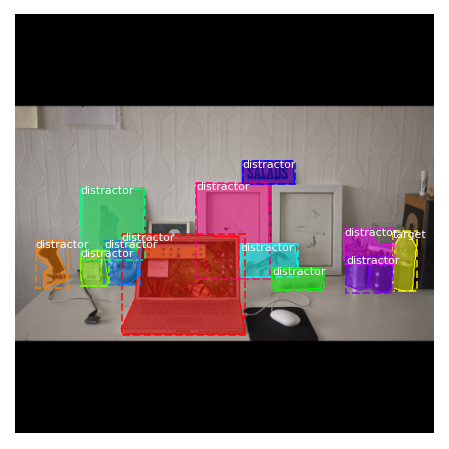

In [62]:
# Test on a random image
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))


Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  252.00000  float64
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


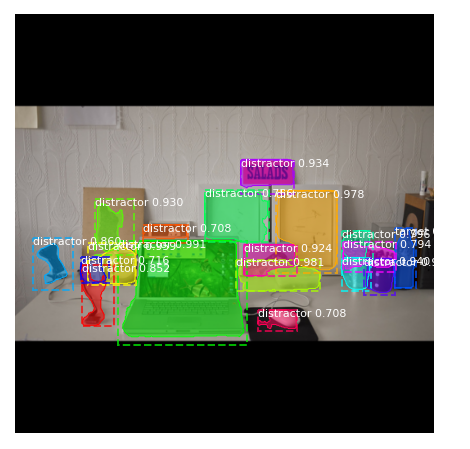

In [63]:
results = model.detect([original_image], verbose=1)

r = results[0]
indices = []

for ind , id in enumerate(r['class_ids']):
  if id==1 and r['scores'][ind]>0.00:
    indices.append(ind)
  if id==2 and r['scores'][ind]>0.0:
    indices.append(ind)
  if id==3 and r['scores'][ind]>0.00:
    indices.append(ind)

ind = np.asarray(indices)

if len(r['masks'][...,ind].shape)==4:
  mask_input = np.squeeze(r['masks'][...,ind])
else:
  mask_input = r['masks'][...,ind]
visualize.display_instances(original_image, r['rois'][ind], mask_input , r['class_ids'][ind], 
                            dataset_test.class_names, r['scores'][ind], ax=get_ax())

In [64]:

# Get activations of a few sample layers
activations = model.run_graph([original_image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10001  float32
res2c_out                shape: (1, 128, 128, 256)    min:    0.00000  max:   25.43206  float32
res3c_out                shape: (1, 64, 64, 512)      min:    0.00000  max:   28.80075  float32
res4w_out                shape: (1, 32, 32, 1024)     min:    0.00000  max:   58.49185  float32
rpn_bbox                 shape: (1, 65472, 4)         min:   -6.56236  max:   52.03016  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


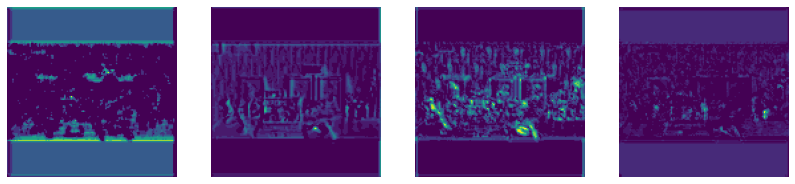

(1, 512, 512, 3)

In [65]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

activations["input_image"].shape


In [66]:
model.keras_model.summary()

filters , bias= model.keras_model.get_layer("res5a_branch2b").get_weights()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

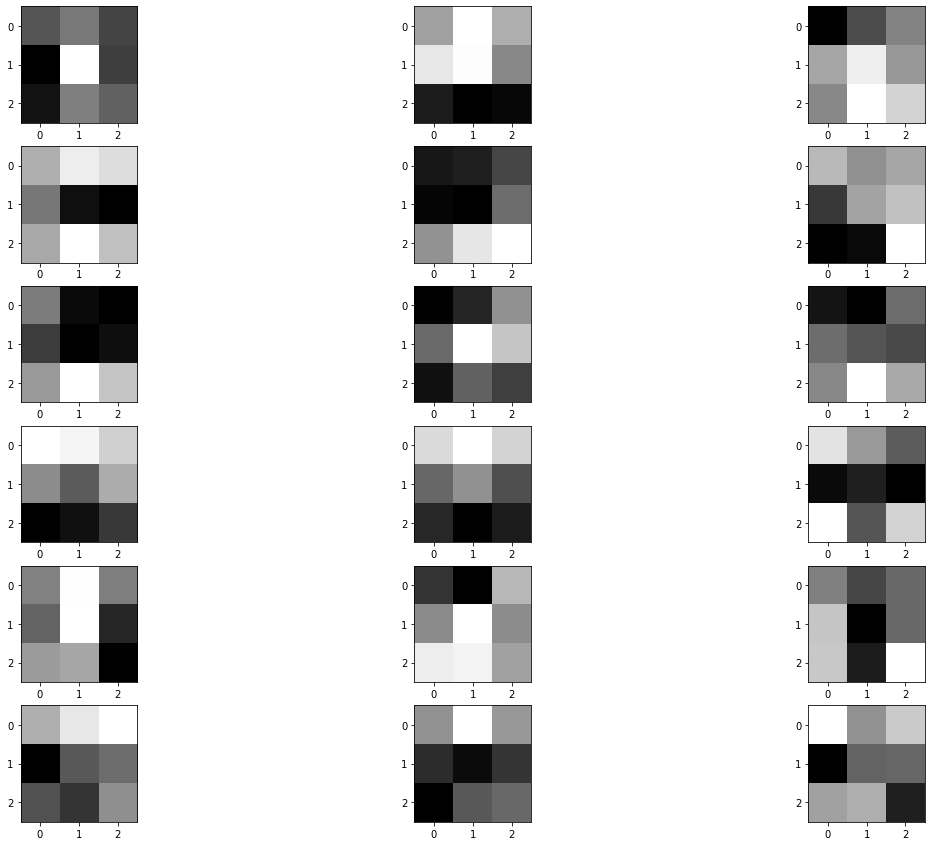

In [67]:
import matplotlib.pyplot as plt

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
  
n_filters =6
ix=1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
plt.show()

In [68]:
from keras import backend as K
# Set up a model that returns the activation values for our target layer
img_width = 512
img_height =512

activations = model.run_graph([original_image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res2a_branch2c",          model.keras_model.get_layer("res2a_branch2c").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

#layer = model.keras_model.get_layer(name='res2a_branch2c').output

#feature_extractor = keras.Model(inputs=model.keras_model.inputs, outputs=layer.output)
filter_index = 0
#layer_output = layer_dict[layer_name].output
loss = K.mean(K.constant(activations["res2a_branch2c"][:,:,:,filter_index], dtype = np.float32))
input_img = K.constant(activations["input_image"], dtype = np.float32)


input_image              shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10001  float32
res2c_out                shape: (1, 128, 128, 256)    min:    0.00000  max:   25.43206  float32
res2a_branch2c           shape: (1, 128, 128, 256)    min:   -8.27545  max:    8.22141  float32
res3c_out                shape: (1, 64, 64, 512)      min:    0.00000  max:   28.80075  float32
res4w_out                shape: (1, 32, 32, 1024)     min:    0.00000  max:   58.49185  float32
rpn_bbox                 shape: (1, 65472, 4)         min:   -6.56236  max:   52.03016  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
